<div style="border:solid Chocolate 2px; padding: 40px">

<b> Айдар, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Критичные ошибки, которые обязательно нужно исправить.
</div>

Я не смогу принять проект, если в нём будет хотя бы одна критичная ошибка или несколько некритичных ошибок - тогда проект нужно будет немного доработать. Но это нестрашно - я обязательно дам тебе подсказку или укажу верное направление.
    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

## Подготовка данных

In [1]:
import pandas as pd
import re
from itertools import groupby
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

In [2]:
try:
    gold_full  = pd.read_csv('gold_industry_full.csv')
    gold_train = pd.read_csv('gold_industry_train.csv')
    gold_test  = pd.read_csv('gold_industry_test.csv')
except:
    gold_full  = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv')
    gold_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv')
    gold_test  = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Данные загрузили - отлично!
    
Здорово, что ты используешь конструкцию ``try-except`` для путей файлов. Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')
    
Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных задать индекс-столбец- за это действие отвечает параметр `index_col`.

In [3]:
# Оценим с чем придется работать
gold_full.info()
gold_train.info()
gold_test.info()
display(gold_full.describe().T)
display(gold_train.describe().T)
display(gold_test.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,19439.0,8.266097,1.955092,0.010000,6.854384,8.125839,9.769917,13.731330
rougher.input.feed_ag,19439.0,8.794927,1.936847,0.010000,7.237967,8.593574,10.213771,14.596026
rougher.input.feed_pb,19339.0,3.598085,1.049486,0.010000,2.887280,3.534895,4.244161,7.142594
rougher.input.feed_sol,19340.0,36.695114,5.145445,0.010000,34.207799,37.202650,40.039133,53.477742
rougher.input.feed_rate,19428.0,478.320042,105.373758,0.002986,416.525453,499.416120,550.172183,717.508837
...,...,...,...,...,...,...,...,...
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
final.output.tail_au,19439.0,3.042467,0.922808,0.000000,2.461138,2.984909,3.571351,8.245022
final.output.tail_ag,19438.0,9.688589,2.328642,0.000000,8.062878,9.743623,11.134294,19.552149
final.output.tail_pb,19338.0,2.705795,0.949077,0.000000,2.040119,2.748730,3.333216,5.804178


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,14579.0,8.352941,1.934376,0.010000,6.932996,8.225284,9.832210,13.731330
rougher.input.feed_ag,14579.0,8.877460,1.922536,0.010000,7.341922,8.715859,10.255843,14.596026
rougher.input.feed_pb,14507.0,3.604221,1.056063,0.010000,2.880490,3.532399,4.257282,7.052325
rougher.input.feed_sol,14502.0,36.561420,5.209823,0.010000,34.093951,37.097511,39.899799,53.475325
rougher.input.feed_rate,14572.0,474.332784,108.503552,0.002986,411.048483,498.187968,549.586552,717.508837
...,...,...,...,...,...,...,...,...
final.output.recovery,14579.0,66.759066,10.619709,0.000000,63.114596,67.962788,72.598187,100.000000
final.output.tail_au,14579.0,3.087939,0.915187,0.000000,2.505287,3.029238,3.614098,8.245022
final.output.tail_ag,14578.0,9.731972,2.358143,0.000000,8.088928,9.818512,11.169187,19.552149
final.output.tail_pb,14504.0,2.719985,0.958929,0.000000,2.036512,2.774847,3.353845,5.804178


,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,4860.0,8.005584,1.993590,1.000000e-02,6.574363,7.812923,9.556589,13.417156
rougher.input.feed_ag,4860.0,8.547348,1.958601,1.000000e-02,6.975898,8.179714,10.084339,14.533698
rougher.input.feed_pb,4832.0,3.579662,1.029377,1.000000e-02,2.903612,3.540772,4.199847,7.142594
rougher.input.feed_sol,4838.0,37.095864,4.926284,1.000000e-02,34.510841,37.499761,40.461315,53.477742
rougher.input.feed_rate,4856.0,490.285103,94.371623,1.278570e-02,434.099695,502.118742,555.596563,702.523396
rougher.input.feed_size,4816.0,59.113400,19.125122,4.636880e-02,47.596984,55.509481,66.661547,363.989699
rougher.input.floatbank10_sulfate,4857.0,12.055735,3.407642,1.890695e-02,9.890429,11.997859,14.496072,30.010759
rougher.input.floatbank10_xanthate,4859.0,6.101308,1.042754,1.578303e-02,5.499808,6.099805,6.802101,9.396928
rougher.state.floatbank10_a_air,4859.0,1108.635895,156.493143,3.007925e+02,999.715729,1001.414798,1202.837565,1521.980372
rougher.state.floatbank10_a_level,4859.0,-368.340127,91.155929,-6.005681e+02,-499.731972,-300.181367,-299.961547,-281.039299


Все столбцы кроме столбца с датой числовые. Есть пропущенные значения. Есть столбцы которые отличаются на порядки, поэтому понадобится шкалирование. Посмотрим как распределена дата между тренировочной и тестовой выборками.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Данные осмотрели - отлично!

In [4]:
display(pd.to_datetime(gold_train.date).describe())
display(pd.to_datetime(gold_test.date).describe())

/tmp/ipykernel_71/3943201928.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.to_datetime(gold_train.date).describe())


count                   14579
unique                  14579
top       2016-04-15 10:00:00
freq                        1
first     2016-01-15 00:00:00
last      2017-12-09 13:59:59
Name: date, dtype: object

/tmp/ipykernel_71/3943201928.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(pd.to_datetime(gold_test.date).describe())


count                    4860
unique                   4860
top       2018-03-04 08:59:59
freq                        1
first     2017-12-09 14:59:59
last      2018-08-18 10:59:59
Name: date, dtype: object

Видно что выборка разбита на тренировочную и тестовую части по признаку даты.

In [5]:
# Проверим что эффективность обогащения рассчитана правильно.
def recovery(output_concentrate_au, input_feed_au, output_tail_au):
    return (output_concentrate_au*(input_feed_au-output_tail_au))/(input_feed_au*(output_concentrate_au-output_tail_au))*100

roughed_recovery_calc = (
    recovery(gold_train['rougher.output.concentrate_au'], gold_train['rougher.input.feed_au'], gold_train['rougher.output.tail_au']))

mean_absolute_error(gold_train['rougher.output.recovery'], roughed_recovery_calc)

9.83758577644259e-15

Ошибка около нуля, эффективность обогащения рассчитана правильно.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Оценили `MAE` между исходным и расчётным значением эффективности обогащения и убедились, что эффективность обогащения рассчитана правильно - отлично!
</div>

In [6]:
# Проверим какие столбцы отсутствуют в тестовом наборе данных
print(missing_cols := set(gold_train.columns) - set(gold_test.columns))

{'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_ag', 'final.output.concentrate_au', 'final.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.recovery', 'final.output.concentrate_pb', 'rougher.output.concentrate_ag', 'final.output.recovery', 'rougher.output.concentrate_sol', 'secondary_cleaner.output.tail_pb', 'final.output.tail_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'final.output.tail_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'secondary_cleaner.output.tail_au', 'rougher.output.tail_au', 'rougher.output.concentrate_pb', 'rougher.output.tail_ag', 'rougher.output.concentrate_au', 'primary_cleaner.output.tail_sol', 'final.output.tail_sol', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_so

В тестовом наборе данных отсутствуют признаки связанные с концентрацией металлов на выходе, в том числе в хвостах. А также некоторые расчётные показатели, которые могут привести к утечке данных.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Проанализировали разницу в признаках между выборками. 

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Здесь стоит вспомнить разницу между онлайн и оффлайн метриками: исходя из понимания, что тестовая выборка имитирует работу модели в реальных условиях протекания технологического процесса, давай подумаем, почему в `train` есть признаки, которые недоступны в `test`?
    
Нужно сделать вывод о причине расхожедния количества признаков между `train` и `test`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Количество признаков между train и test расходится потому что некоторые метрики нельзя измерить на месте, например, возможно, для измерения концентрации метала надо отнести образцы в лабораторию. Другими словами train условно исторические данные, а test данные которые мы только получили и некоторые признаки ещё просто не успели добавить.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Всё верно!

In [7]:
# Подготовим данные и заполним пропущенные данные
# Столбец с датой для предсказания мы использовать не будем,
# но информация нам нужна, поэтому запишем его в индекс.
print('проверим столбец на дубликаты, full df', sum(gold_full.date.duplicated()))
print('проверим столбец на дубликаты, train df', sum(gold_train.date.duplicated()))
print('проверим столбец на дубликаты, test df', sum(gold_test.date.duplicated()))
gold_full.index = pd.to_datetime(gold_full.date)
gold_full.drop('date', inplace=True, axis=1)
gold_train.index = pd.to_datetime(gold_train.date)
gold_train.drop('date', inplace=True, axis=1)
gold_test.index = pd.to_datetime(gold_test.date)
gold_test.drop('date', inplace=True, axis=1)

проверим столбец на дубликаты, full df 0
проверим столбец на дубликаты, train df 0
проверим столбец на дубликаты, test df 0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Дубликатов нет - отлично!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит сделать промежуточные выводы о проделанной работе в блоке.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

На данном этапе работы была проведена первоначальная оценка данных, оценена правильность рассчёта эффективности обогащения, найдены столбцы которые отсутствуют в тестовом наборе данных и удалён столбец с датой, который стал теперь индексом.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [8]:
# Как мы могли убедиться выше, пропущенных значений по каждому столбцу не очень много,
# поэтому заполним медианой.
gold_test.fillna(method='bfill', inplace=True)
gold_train.fillna(method='bfill', inplace=True)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пропуски заполнены.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
Замена на средние или медианы на всегда будет корректно работать, так как состояние одного и того же объекта в разное время может быть разным, и это не очень корректный шаг для данных с временной меткой.
        
Лучше использовать методы заполнения предыдущим или следующим значением (из условий проекта мы знаем, что соседние значения похожи) или использовать инструменты машинного обучения для заполнения пропусков из семейства `sklearn.impute`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

## Анализ данных

In [9]:
# Сравним концентрации металлов золота, серебра и свинца на разных стадиях.
def get_metal_cols(metal):
    return [f'rougher.input.feed_{metal}'] + [
        m for m in gold_full.columns if re.search('concentrate_'+metal, m)
    ]
au_cols = get_metal_cols('au')
ag_cols = get_metal_cols('ag')
pb_cols = get_metal_cols('pb')
display(gold_full[au_cols].describe())
display(gold_full[ag_cols].describe())
display(gold_full[pb_cols].describe())
gold_train.columns

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.266097,19.772000,32.119400,44.076513
std,1.955092,3.753600,5.627611,5.129784
min,0.010000,0.000000,0.000000,0.000000
25%,6.854384,18.802523,30.463140,43.402215
50%,8.125839,20.280214,32.841295,45.011244
75%,9.769917,21.717843,35.048006,46.275313
max,13.731330,28.824507,45.933934,52.756638


,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000,19438.000000
mean,8.794927,11.994759,8.442408,5.168470
std,1.936847,2.733862,2.054465,1.372348
min,0.010000,0.000000,0.000000,0.000000
25%,7.237967,10.628337,7.263288,4.251240
50%,8.593574,12.098115,8.507298,5.066094
75%,10.213771,13.736996,9.809001,5.895527
max,14.596026,24.480271,16.081632,16.001945


,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19339.000000,19439.000000,19323.000000,19438.000000
mean,3.598085,7.606272,9.829530,9.978895
std,1.049486,1.796757,2.556843,1.669240
min,0.010000,0.000000,0.000000,0.000000
25%,2.887280,6.725987,8.702328,9.137262
50%,3.534895,7.742580,10.152433,10.102433
75%,4.244161,8.565199,11.424971,11.035769
max,7.142594,13.617072,17.081278,17.031899


Index(['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_f

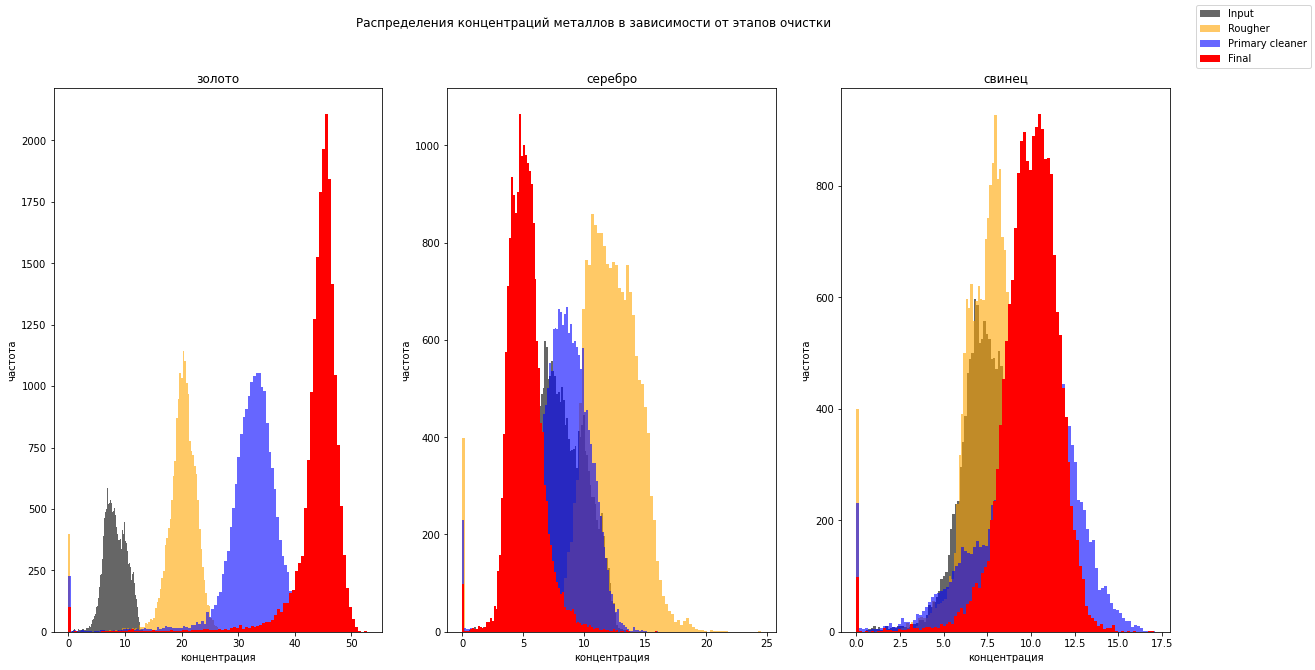

In [10]:
# Для наглядности построим график
figure, axis = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

axis[0].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[0].hist(gold_full[au_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[0].hist(gold_full[au_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[0].hist(gold_full[au_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[0].set_xlabel('концентрация')
axis[0].set_ylabel('частота')
axis[0].set_title('золото')
axis[1].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[1].hist(gold_full[ag_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[1].hist(gold_full[ag_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[1].hist(gold_full[ag_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[1].set_xlabel('концентрация')
axis[1].set_ylabel('частота')
axis[1].set_title('серебро')
axis[2].hist(gold_full[au_cols].iloc[:, 0], bins=100, color='black', alpha=0.6, label='Input')
axis[2].hist(gold_full[pb_cols].iloc[:, 1], bins=100, color='orange', alpha=0.6, label='Rougher')
axis[2].hist(gold_full[pb_cols].iloc[:, 2], bins=100, color='blue', alpha=0.6, label='Primary cleaner')
axis[2].hist(gold_full[pb_cols].iloc[:, 3], bins=100, color='red', label='Final')
axis[2].set_xlabel('концентрация')
axis[2].set_ylabel('частота')
axis[2].set_title('свинец')
figure.suptitle('Распределения концентраций металлов в зависимости от этапов очистки');
handles, labels = axis[0].get_legend_handles_labels()
figure.legend(handles, labels);

Из распределений видно что концентрация золота растёт, концентрация серебра немного повышается после флотации, но снижается на остальных этапах очистки, в то время как концентрация свинца незначительно увеличивается после флотации, но практически не меняется после. Также на графиках обнаружились значения, где концентрация металла равна 0, во всех случаях больше всего таких значений на этапе флотации и меньше всего после второй очистки.

In [11]:
# Нулевая концентрация металлов это явный артефакт, поэтому надо удалить такие наблюдения.
threshold = 1e-1
conc_metal_cols = au_cols + ag_cols + pb_cols
for conc in conc_metal_cols:
    gold_train.drop(gold_train[gold_train[conc]<threshold].index, inplace=True)

In [12]:
# Проверим что такие наблюдения удалены из тренировочного датасета
gold_train[gold_train[conc_metal_cols[0]]<threshold].index

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

Артефакты успешно удалены

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследована концентрация металлов на разных стадиях обработки, проанализирована динамика концентрации в зависимости от этапа техпроцесса - отлично, тут всё верно.
    
Круто, что были отмечены и удалены нулевые значения - это действительно аномалия, подлежащая удалению.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Сверься с брифом проекта и добавь в исследование потерянный этап.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Вывод имеется в виду? Если да, то вывод только один, концентрация золота растёт при том что концентрация других металлов меняется незначительно либо не меняется вовсе. Я думал это понятно из описания которое есть.

А так у меня вот что в описании проекта:
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения? Опишите выводы.
    
А потом 2.2 на сравнение гранул.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нет, с выводом всё ок, замечание по полноте анализа: у тебя перечислены этапы `в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате`, то есть 4 этапа процесса, у тебя выше визуализировано 3 - один потерялся.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [13]:
# Сравним размер гранул между тренировочной и тестовой выборками
display(gold_train['rougher.input.feed_size'].describe())
display(gold_test['rougher.input.feed_size'].describe())
# Выглядит очень похоже

count    13881.000000
mean        58.810206
std         23.356806
min          0.049194
25%         47.166841
50%         54.313886
75%         64.228440
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    4860.000000
mean       59.080175
std        19.441844
min         0.046369
25%        47.605339
50%        55.414175
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64

H0: разницы между средним значением размера гранул в тренировочной и тестовой выборке нет, 
H1: разница между средним значением размера гранул в тренировочной и тестовой выборке есть
P-value: 0.4301274126223197
pval > alpha, не можем отвергнуть H_0 в пользу H_1, размер гранул одинаковый.


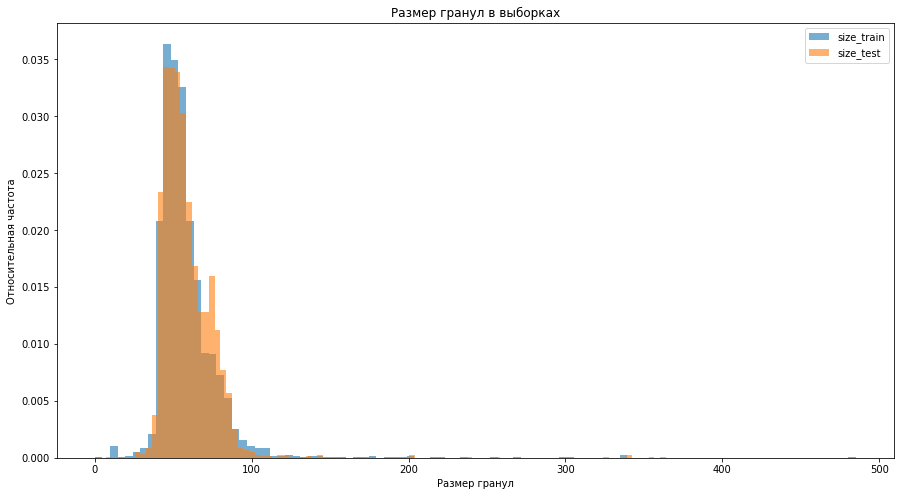

In [14]:
# Докажем что выборки равны, попытавшись доказать обратное.
pval = st.ttest_ind(gold_train['rougher.input.feed_size'], 
                    gold_test['rougher.input.feed_size'],
                    equal_var=False
                   ).pvalue
print('''H0: разницы между средним значением размера гранул в тренировочной и тестовой выборке нет, 
H1: разница между средним значением размера гранул в тренировочной и тестовой выборке есть''')
print('P-value:', pval)
if pval < 0.05:
    print('pval < alpha, H_0 отвергается, выборки не равны, размер гранул разный')
else:
    print('pval > alpha, не можем отвергнуть H_0 в пользу H_1, размер гранул одинаковый.')
figure, axis = plt.subplots(figsize=(15, 8))
axis.hist(gold_train['rougher.input.feed_size'], bins=100, density=True, alpha=0.6, label='size_train')
axis.hist(gold_test['rougher.input.feed_size'], bins=100, density=True, alpha=0.6, label='size_test')
axis.set_xlabel('Размер гранул')
axis.set_ylabel('Относительная частота')
axis.set_title('Размер гранул в выборках')
axis.legend();

Можно статистически обоснованно считать что размер гранул одинаковый. Также на графике видно что распределения почти полностью перекрывают друг друга.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Сравнили размеры гранул сырья на обучающей и тестовой выборках для этапа `rougher.input.feed_size` - отлично, распределения между выборками действительно схожи, следовательно модель будет корректно работать.

Интересный подход к выполнению задания:)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

1. При проведении тестов важно формулировать гипотезы.
2. Ннужно также вывести на экран `p-value`.
3. Не настроен параметр `equal_var` - выборки разного размера.
4. Помимо теста, нужно сделать графическое сравнение - используй нормированные гистограммы, так как выборки разного размера.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

1. Гипотезы. При проведении стат тестов мы обчно оперируем понятием среднего, соттветственно гипотезы должны звучать как о наличии или отсутствии стат значимой разницы в среднем гранул сырья между выборками.
2. `ttest`. Так как наши выборки существенно отличаются по размерам, нам нужно настраивать `equal_var=False` для корректной работы теста.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,20.640600,39.373032,50.332682,59.223099
std,4.494362,6.863389,7.671672,6.097603
min,0.030000,0.000000,0.000000,0.000000
25%,17.252879,38.394639,50.038524,59.298323
50%,20.141216,40.312648,51.905758,60.306921
75%,23.797381,42.365102,53.386172,61.096667
max,33.498784,55.568687,60.269003,64.968881


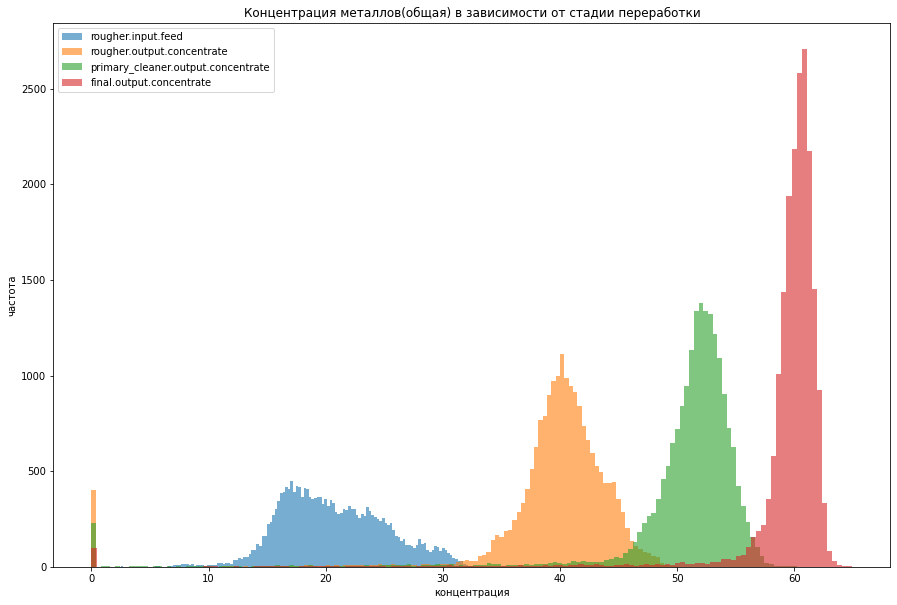

In [15]:
# Исследуем суммарную концентрацию металлов на разных стадиях. Начнём с подготовки данных.
total_concentration_cols = []
for metal in ('au', 'ag', 'pb'):
    total_concentration_cols.extend([column for column in gold_full.columns if re.search('(concentrate|feed)', column) and column.endswith(metal)])
total_concentration_cols_grouped = {}
for key, val in groupby(total_concentration_cols, lambda x: x.rsplit('_', 1)[0]):
    total_concentration_cols_grouped.setdefault(key, []).extend(val)
total_concentration_cols_sum = {}
for key, val in total_concentration_cols_grouped.items():
    total_concentration_cols_sum[key] = gold_full[val].sum(axis=1)
total_concentration_cols_sum = pd.DataFrame(total_concentration_cols_sum)
# Теперь можно приступить к анализу
display(total_concentration_cols_sum.describe())
figure, axis = plt.subplots(figsize=(15, 10))
axis.hist(total_concentration_cols_sum.iloc[:, 0], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[0])
axis.hist(total_concentration_cols_sum.iloc[:, 1], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[1])
axis.hist(total_concentration_cols_sum.iloc[:, 2], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[2])
axis.hist(total_concentration_cols_sum.iloc[:, 3], bins=150, alpha=0.6, label=total_concentration_cols_sum.columns[3])
axis.legend()
axis.set_xlabel('концентрация')
axis.set_ylabel('частота')
axis.set_title('Концентрация металлов(общая) в зависимости от стадии переработки');

Видно, что концентрация стабильно растёт от исходного сырья к финальному концентрату. Распределения у стадий похожи на нормальное, за исключением концентрации на этапе флотации. Наименьшая сигма визуально у финального сырья. С учетом того как выглядят распределения по стадиям для отдельных металлов концентрация растёт в основном за счёт золота. __Нули__ из тренировочного и тестового датасетов были заполнены медианой выше.

__ВЫВОД__: На этом этапе были сравнены распределения концентраций: концентрация золота стабильно растёт в зависимости от стадии переработки. Затем были сравнены размеры гранул: разницы между ними не оказалось. После чего были посторены гистограммы распределения для всех стадий очистки по сумме концентраций металлов: концентрация металлов растёт одновременно со стадией очистки. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследована суммарная концентрация металлов на разных стадиях техпроцесса - отлично!

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> 

Здесь заканчивается стрктурный блок работы - стоит сделать промежуточные выводы о проделанной работе в блоке.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Добавил вывод
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

## Модель

In [16]:
# Подготовим данные для моделирования, попробуем заполнить отсутствующие столбцы 
# в тестовой выборке из полной датасета.
target_cols = [col for col in list(missing_cols) if col.endswith('recovery')]
gold_test = gold_test.join(gold_full[target_cols].loc[gold_test.index, :])

In [17]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4860 non-null   float64
 3   rougher.input.feed_sol                      4860 non-null   float64
 4   rougher.input.feed_rate                     4860 non-null   float64
 5   rougher.input.feed_size                     4860 non-null   float64
 6   rougher.input.floatbank10_sulfate           4860 non-null   float64
 7   rougher.input.floatbank10_xanthate          4860 non-null   float64
 8   rougher.state.floatbank10_a_air             4860 non-null   float64
 9   rougher.state.floatbank10_a_level           4860 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В `test` добавили целевые признаки из `full`, используя дату как ключ при соединении - отлично!

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
С учётом замечания на этапе анализа разницы признаков в выборках давай подумаем, что можно добавить в `test`, а что нелья?

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
А точно ли есть пропуски? Проверь после исправления замечания выше.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Решил добавить только целевые признаки. Пропуски исчезли.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [18]:
target_cols

['rougher.output.recovery', 'final.output.recovery']

In [19]:
# создадим целевые признаки
train_target_rougher = gold_train['rougher.output.recovery']
gold_train.drop('rougher.output.recovery', axis=1, inplace=True)
train_target_final = gold_train['final.output.recovery']
gold_train.drop('final.output.recovery', axis=1, inplace=True)
test_target_rougher = gold_test['rougher.output.recovery']
gold_test.drop('rougher.output.recovery', axis=1, inplace=True)
test_target_final = gold_test['final.output.recovery']
gold_test.drop('final.output.recovery', axis=1, inplace=True)

In [20]:
# Удалим столбцы которых нет в тестовой таблице чтобы избежать утечки данных
gold_train.drop(missing_cols, axis=1, inplace=True, errors='ignore')
gold_test.drop(missing_cols, axis=1, inplace=True, errors='ignore')

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Целевые признаки выделены некорректно - сверья с условием проекта и убедись, что предсказываешь то, что нужно.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

Данные подготовлены для моделирования.

In [21]:
# Напишем функцию sMAPE
def smape(target, pred):
    diff_ = (target - pred).abs()
    sum_ = (target + pred)/2
    percent_ = diff_/sum_*100
    return percent_.sum()/len(percent_)

def resulting_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher+0.75*smape_final

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Есть функция для оценки `sMAPE` - супер!
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Ошибка не может быть отрицательной.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [22]:
scorer = make_scorer(smape, greater_is_better=False)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Пользовательский скорринг `make_scorer` настроен неверно: так как метрика `sMAPE` применяется для задач регрессии, то она тем лучше, чем ниже - это нужно учитывать при создании скорринга для кросс-валидации, так как по умолчанию инструменты кросс-валидации вроде `cross_val_score` и `GridSearchCV/RandomizedSearchCV` умеют только максимизировать метрику качества. Поэтому при создании скорринга с помощью `make_scorer` важно настроить параметр `greater_is_better=False`, чтобы оптимизируемая метрика минимизировалась, а не максимизировалась - таким образом задача максимизации будет решаться через задачу минимизации обратной функции.
    
Также при настройке этого параметра получаемая метрика будет отрицательной: это особеность работы `make_scorer` с настроенным параметром `greater_is_better=False`. Поэтому при выводе метрики на экран её стоит сделать положительной: взять по модулю, домножить на `-1` или просто указать `-` при выводе на экран, вроде `print(-a)`.
        
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [23]:
# Приступим к моделированию
# Для начала выберем лучшую модель на параметрах по умолчанию,
# а затем проведём тюнинг гиперпараметров лучшей модели.
# Для начала попробуем модель Ridge
# model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=44))])
# smape_score_r_pipe_rougher = cross_val_score(
#     model_r_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
# print(f'sMAPE_avg ROUGHER = {smape_score_r_pipe_rougher}')
# model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
# smape_score_r_pipe_final = cross_val_score(
#     model_r_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
# print(f'sMAPE_avg FINAL = {smape_score_r_pipe_final}')
# print(f'resulting sMAPE = {resulting_smape(smape_score_r_pipe_rougher, smape_score_r_pipe_final)}')

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Оставлю первую оценку ridge в виде коммента для истории тогда
</div>

In [24]:
# Посмотрим на линейную регрессию
model_l_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
smape_score_l_pipe_rougher = cross_val_score(
    model_l_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg ROUGHER = {smape_score_l_pipe_rougher}')
model_l_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
smape_score_l_pipe_final = cross_val_score(
    model_l_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg FINAL = {smape_score_l_pipe_final}')
print(f'resulting sMAPE = {resulting_smape(smape_score_l_pipe_rougher, smape_score_l_pipe_final)}')

sMAPE_avg ROUGHER = 5.922308123711573
sMAPE_avg FINAL = 9.619223888488799
resulting sMAPE = 8.694994947294493


In [25]:
model_lo_pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=44))])
smape_score_lo_pipe_rougher = cross_val_score(
    model_lo_pipe, gold_train, train_target_rougher, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg ROUGHER = {smape_score_lo_pipe_rougher}')
model_lo_pipe = Pipeline([('scaler', StandardScaler()), ('model', Lasso(random_state=44))])
smape_score_lo_pipe_final = cross_val_score(
    model_lo_pipe, gold_train, train_target_final, cv=10, scoring=scorer).mean()*-1
print(f'sMAPE_avg FINAL = {smape_score_lo_pipe_final}')
print(f'resulting sMAPE = {resulting_smape(smape_score_lo_pipe_rougher, smape_score_lo_pipe_final)}')

sMAPE_avg ROUGHER = 6.090250394403746
sMAPE_avg FINAL = 8.741062367244645
resulting sMAPE = 8.07835937403442


По результатам кросс валидации с минимальным отрывом от линейной регрессии побеждает модель Ridge. Лассо показала наихудший результат.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Исследовали несколько моделей на кросс-валидации.
    

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Для каждой модели на основе двух оценок нужно вывести взвешенную. Тут и далее.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

поправил
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [26]:
# Проведём тюнинг гиперпараметров для Ridge
model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(random_state=44))])
param_grid = {
    'model__alpha': list(range(1, 11)),
}

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

1. Если для модели оптимизируются гиперпараметры, то оценка базовой модели на кросс-валидации не требуется, так как она по сути является проверкой более низкого уровня.
    
2. Параметр `fit_intercept` не перебирается, а настраивается у модели в момент её инициализации, выбор значения делается исходя из того, как были подготовлены данные. Обратись к документации и выбери корректное значение для этого гиперпараметра.
    
3. Хотя бы для одной модели нужно оптимизировать не менее двух гиперпараметров - с учётом текущего замечания у `Ridge`, кроме `alpha`, оптимизировать нечего, поэтому стоит выполнить оптимизацию и для другой модели.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправил
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Сп.п.1 - модель `Ridge` оценивается дважды.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Ну я думал что она не сильно мешает, но в общем закомментил первую оценку, где кросс-валидацией. Оставил что-бы вспоминать ошибки потом было легче.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [27]:
grid_search_r = GridSearchCV(model_r_pipe, param_grid, scoring=scorer)
grid_search_r.fit(gold_train, train_target_rougher)
rouger_score = pd.DataFrame(grid_search_r.cv_results_).sort_values('mean_test_score', ascending=False)
grid_search_r.fit(gold_train, train_target_final)
final_score = pd.DataFrame(grid_search_r.cv_results_).sort_values('mean_test_score', ascending=False)

In [28]:
display(rouger_score)
display(final_score)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.120685,0.030323,0.038177,0.035492,10,{'model__alpha': 10},-8.824014,-5.893614,-6.910610,-4.784803,-9.389053,-7.160419,1.734653,1
8,0.175027,0.035163,0.021234,0.030200,9,{'model__alpha': 9},-8.823341,-5.892345,-6.913784,-4.784439,-9.391175,-7.161017,1.735264,2
7,0.152905,0.042802,0.009910,0.005456,8,{'model__alpha': 8},-8.822653,-5.891063,-6.916964,-4.784065,-9.393304,-7.161610,1.735879,3
6,0.191427,0.004525,0.028305,0.036133,7,{'model__alpha': 7},-8.821953,-5.889762,-6.920151,-4.783682,-9.395447,-7.162199,1.736503,4
5,0.190147,0.005710,0.008684,0.001806,6,{'model__alpha': 6},-8.821268,-5.888443,-6.923346,-4.783289,-9.397588,-7.162787,1.737135,5
4,0.176697,0.033928,0.023628,0.029141,5,{'model__alpha': 5},-8.820586,-5.887106,-6.926549,-4.782886,-9.399728,-7.163371,1.737775,6
3,0.141841,0.042347,0.054550,0.038537,4,{'model__alpha': 4},-8.819887,-5.885750,-6.929760,-4.782473,-9.401877,-7.163949,1.738420,7
2,0.118833,0.039227,0.022037,0.034256,3,{'model__alpha': 3},-8.819185,-5.884375,-6.932980,-4.782049,-9.404023,-7.164522,1.739071,8
1,0.099217,0.005853,0.037927,0.038474,2,{'model__alpha': 2},-8.818469,-5.882978,-6.936207,-4.781614,-9.406168,-7.165087,1.739727,9
0,0.087212,0.061346,0.031697,0.030014,1,{'model__alpha': 1},-8.817746,-5.881560,-6.939443,-4.781172,-9.408316,-7.165647,1.740389,10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.133181,0.045162,0.024630,0.032085,10,{'model__alpha': 10},-10.451653,-8.201874,-8.816601,-8.883317,-11.453520,-9.561393,1.202955,1
8,0.136018,0.042471,0.022631,0.030364,9,{'model__alpha': 9},-10.450864,-8.203661,-8.816824,-8.883722,-11.457385,-9.562491,1.203577,2
7,0.104508,0.009119,0.037481,0.036434,8,{'model__alpha': 8},-10.450066,-8.205452,-8.817053,-8.884152,-11.461286,-9.563602,1.204208,3
6,0.132755,0.044438,0.007534,0.001653,7,{'model__alpha': 7},-10.449348,-8.207255,-8.817285,-8.884586,-11.465198,-9.564735,1.204851,4
5,0.154656,0.043338,0.025689,0.036384,6,{'model__alpha': 6},-10.448657,-8.209056,-8.817518,-8.885026,-11.469123,-9.565876,1.205505,5
4,0.156251,0.042172,0.025733,0.029585,5,{'model__alpha': 5},-10.447966,-8.210853,-8.817763,-8.885471,-11.473059,-9.567022,1.206162,6
3,0.135022,0.042019,0.023157,0.028359,4,{'model__alpha': 4},-10.447460,-8.212656,-8.818012,-8.885940,-11.477004,-9.568215,1.206847,7
2,0.156457,0.041456,0.021783,0.027785,3,{'model__alpha': 3},-10.447205,-8.214472,-8.818260,-8.886420,-11.480962,-9.569464,1.207569,8
1,0.171977,0.033765,0.009007,0.003513,2,{'model__alpha': 2},-10.447008,-8.216305,-8.818507,-8.886906,-11.484958,-9.570737,1.208309,9
0,0.102180,0.001438,0.053142,0.036167,1,{'model__alpha': 1},-10.447320,-8.218149,-8.818751,-8.887396,-11.488963,-9.572116,1.209124,10


Как в случае с флотацией, так и с финальной концентрацией для модели Ridge оптимальным получается число alpha равное 10.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> Чтобы узнать лучшие гиперпараметры модели, можно обратить к атрибуту `best_params_` у `GridSearchCV` после обучения.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Учту
</div>

In [29]:
# Оценим модель с двумя гиперпараметрами
model_en_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=44))])
param_grid = {
    'model__n_estimators': np.arange(10, 31, 10),
    'model__max_depth': [None] + [i for i in range(2, 7)]
}
# Финальная проверка что все ячейки работают перед отправкой на ревью. Параметры уже подобраны ранее.
param_grid = {
    'model__n_estimators': [10],
    'model__max_depth': [5]
}

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для гиперпараметра `max_depth` рассматривается очень длинная последовательность: деревья с большой глубиной склонны к переобучению, а обучаются и предсказывают результат они дольше, поэтому делать их слишком глубокими не стоит - оптимальное значение почти всегда лежит в диапазоне от 2 до 5-6. Кроме того, можно попробовать значение `None` - в итоге оптимальная последовательность может выглядеть как `[None] + [i for i in range(2, 7)]`.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Вставил ваш вариант, посмотрим что получится.
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Прогнал на вашем варианте, получилось тоже самое, чего конечно и следовало ожидать.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Да, но, скорее всего, это было быстрее, чем на прошлом:)

In [30]:
grid_search_en = GridSearchCV(model_en_pipe, param_grid, scoring=scorer)
grid_search_en.fit(gold_train, train_target_rougher)
rouger_score_en = pd.DataFrame(grid_search_en.cv_results_).sort_values('mean_test_score', ascending=False)
grid_search_en.fit(gold_train, train_target_final)
final_score_en = pd.DataFrame(grid_search_en.cv_results_).sort_values('mean_test_score', ascending=False)

In [31]:
display(rouger_score_en)
display(final_score_en)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.589595,0.032326,0.005747,0.000652,5,10,"{'model__max_depth': 5, 'model__n_estimators':...",-7.977151,-4.700108,-6.748321,-5.370106,-6.95244,-6.349625,1.170602,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.600001,0.059549,0.00519,0.000046,5,10,"{'model__max_depth': 5, 'model__n_estimators':...",-9.484455,-6.999586,-9.704044,-9.609578,-9.878925,-9.135318,1.075599,1


Случайный лес хоть и долгий, но лучше чам Ridge. В дальнейшем будем использовать его. Как ни странно выигрывают параметры с минимальной глубиной и количеством деревьев.

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Для `Ridge` оптимизировали гиперпараметры и вывели оценку на кросс-валидации.
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>

Оценку лучшей модели нужно вывести из `best_score_`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Выделил лучшую модель на основе столбца `mean_test_score`, `best_score_` берётся оттуда, я проверял.
</div>

<div class="alert alert-success">
    
<h2> Комментарий ревьюера мю2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Да, окей, с сортировкой по `mean_test_score` тоже можно.

In [32]:
# # Проверим модель на тестовой выборке
# model_r_pipe = Pipeline([('scaler', StandardScaler()), ('model', Ridge(
#     alpha=10, fit_intercept=True,random_state=44
# ))])
# model_r_pipe.fit(gold_train, train_target_rougher)
# predicted_rougher = model_r_pipe.predict(gold_test[gold_train.columns])
# model_r_pipe.fit(gold_train, train_target_final)
# predicted_final = model_r_pipe.predict(gold_test[gold_train.columns])

# smape_rougher = smape(test_target_rougher, predicted_rougher)
# smape_final = smape(test_target_final, predicted_final)
# result_smape = 0.25*smape_rougher+0.75*smape_final
# print(f'sMAPE Rougher = {smape_rougher}, sMAPE Final = {smape_final}')
# print('Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)')
# print(f'Итоговый sMAPE = {result_smape}')

<div class="alert alert-success">
    
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Лучшую модель оценили на `test`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Это модель ridge, она показала хуже результат чем случайный лес. Так что закомменчу её, пусть останется для истории.
</div>

In [33]:
# Проверим лучшую модель на тестовой выборке, так совпало что
# гиперпараметры одинаковые для стадий rougher и final.
model_rf_pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', RandomForestRegressor(
        n_estimators=10, max_depth=5
    ))])
model_rf_pipe.fit(gold_train, train_target_rougher)
predicted_rougher = model_rf_pipe.predict(gold_test[gold_train.columns])
model_rf_pipe.fit(gold_train, train_target_final)
predicted_final = model_rf_pipe.predict(gold_test[gold_train.columns])

smape_rougher = smape(test_target_rougher, predicted_rougher)
smape_final = smape(test_target_final, predicted_final)
result_smape = resulting_smape(smape_rougher, smape_final)
print(f'sMAPE Rougher = {smape_rougher}, sMAPE Final = {smape_final}')
print('Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)')
print(f'Итоговый sMAPE = {result_smape}')

sMAPE Rougher = 3.8654784467129892, sMAPE Final = 7.396489761850672
Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)
Итоговый sMAPE = 6.513736933066251


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
На `test` оцениваем только одну модель, лучшую по итогам кросс-валидации. Эта концепция находит своё отражение в условиях эксплуатации модели в реальной среде: в промышленной эксплуатации не работает несколько моделей одновременно - в промышленную эксплуатацию запускают только одну модель, которая была выбрана из нескольких в ходе промежуточной оценки. Так же и здесь - тестовая выборка имитирует поток реальных данных, и с этим потоком должна работать только одна модель.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Закомментил лишнюю проверку на тест данных. Не удаляю для истории, что-бы потом было легче вспоминать и понимать к чему комментарии.</div>


<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

In [34]:
# Сравним полученные результаты с DummyRegressor,
# который по умолчанию предсказывает средние значения
model_dummy_pipe = Pipeline(
    [('scaler', StandardScaler()), ('model', DummyRegressor())])
model_dummy_pipe.fit(gold_train, train_target_rougher)
predicted_rougher = model_dummy_pipe.predict(gold_test[gold_train.columns])
model_dummy_pipe.fit(gold_train, train_target_final)
predicted_final = model_dummy_pipe.predict(gold_test[gold_train.columns])

smape_rougher = smape(test_target_rougher, predicted_rougher)
smape_final = smape(test_target_final, predicted_final)
result_smape = resulting_smape(smape_rougher, smape_final)
print(f'sMAPE Rougher = {smape_rougher}, sMAPE Final = {smape_final}')
print('Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)')
print(f'Итоговый sMAPE = {result_smape}')

sMAPE Rougher = 6.102041745972187, sMAPE Final = 9.256866252215879
Итоговый sMAPE складывается из 25%*sMAPE(rougher) + 75%*sMAPE(final)
Итоговый sMAPE = 8.468160125654956


Разница с DummyRegressor не очень большая, но есть. 8.5 у Dummy против 6.5 у случайного леса. Отдельные показатели на этапе флотации и очистки тоже ниже у случайного леса. Вывод: мы делали модель не зря.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
Очень важно также проверить лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели, которая предсказывала бы константу - вдруг окажется, что не было бы большого смысла заниматься созданием новых признаков, тюнингом и кросс-валидацией моделей, если можно было бы просто предсказывать среднее значение тренировочной выборки? 
    
В качестве константной модели можно использовать `DummyRegressor` (https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) -  эта модель как раз создана для генерирования константных предсказаний.
    
Важно, чтобы результат тестирования нашей модели на тествой выборке был лучше, чем результат константной модели - в противном случае наша модель является бесполезной, так как все наши усилия над проектом не принесли результата, а можель, просто предсказывющая среднее на `train`, делает нашу работу лучше.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Поправил
</div>

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Исполни, пожалуйста, код, чтобы я мог проверить твой результат.
  

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Запустил код
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации⚠️:</b> Лайфхак для ускорения работы: раз ты уже знаешь оптимальные гиперпараметры для своих моделей, для ускорения перезапуска проекта (как в этом проекте, так и в дальнейшем) я рекомендую записывать лучшие гиперпараметры в новую сетку поверх основной: старая нужна, чтобы ревьюер понимал, какие гиперпараметры были исследованы, а новая, усечённая, будет содержать только лучшие значения, чтобы `GridSearchCV`  быстрее отрабатывал. Концепт:
    
    #первый раз запускали GS с такой сеткой
    params = {
    
    'max_depth': range(1, 10),
    'n_estimators': range(10, 100, 10)
    }

    #ранее запустили GS, получили оптимальное max_depth=2 и n_estimators=50
    #делаем новую сетку, старую оставляем ранее, чтобы была видна история (новая перезапишет старую), и уже запускаем сам GS
    
    params = {
        
        'max_depth': range(1, 10),
        'n_estimators': range(10, 100, 10)
    }
    
    params = {
        
        'max_depth': [2],
        'n_estimators': [50]
    }
    
    grid_search = GridSearchCV(model, params, scoring=scorer)
    grid_search.fit(train, train_target)

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

учел
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Учтено.

В ходе работ была выполнена подготовка данных, добавлены отсутствующие столбцы в тестовую выборку. Отсутствующие значения заполнены медианой в тестовой и тренировочной выборках. В целом по металлам концентрация растёт вместе со стадией обогащения за счёт золота, однако для серебра всё наоборот. Для свинца рост не выражен, разницы между первым и вторым этапами очистки практически нет. Из рассмотренных моделей наиболее подходящей оказалась модель RandomForestRegressor. Модель рабочая, судя по метрике sMAPE предсказывает лучше чем DummyRegressor.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отличный итоговый вывод по проекту!

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Айдар, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.

Работа с моделями также выполнена отлично: исследовано несколько алгоритмов, проведён подбор гиперпараметров с помощью `GridSearchCV`, выполнена промежуточная оценка моделей на кросс-валидации - молодец!
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.2.

Айдар, продолжаем работу над проектом - актуальные замечания отмечены комментариями с меткой `v.2`.
    
Жду тебя снова:)

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту v.3.

Айдар, все замечания учтены - проект принят!
    
Спасибо за хорошую работу над проектом, желаю успехов в дальнейшем обучении:)